In [1]:
import pandas as pd
import numpy as np
import datetime
from sklearn.preprocessing import MinMaxScaler
#pd.options.display.float_format = '{:.0f}'.format

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout
from keras.layers import GRU, Bidirectional
from keras.optimizers import SGD
from sklearn import metrics
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


C:\anaconda\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
forex_df = pd.read_csv("Dataset\\Forex_data.csv")
forex_df['Series Description'] = pd.to_datetime(forex_df['Series Description'], format="%d-%m-%Y")

inflation_df_Ind = pd.read_csv("Dataset\\Consumer_Price_Index_India.csv")
inflation_df_Ind['DATE'] = pd.to_datetime(inflation_df_Ind['DATE'], format="%Y-%m-%d")

inflation_df_Ind = inflation_df_Ind.rename(columns={'DATE': 'DATE_Inf_Ind', 'CPALTT01INM659N' : 'Inflation_Ind'})

inflation_df_us = pd.read_csv("Dataset\\Consumer_Price_Index_USA.csv")
inflation_df_us['DATE'] = pd.to_datetime(inflation_df_us['DATE'], format="%Y-%m-%d")

inflation_df_us = inflation_df_us.rename(columns={'DATE': 'DATE_Inf_US', 'CPALTT01USM657N' : 'Inflation_US'})

df = pd.merge_asof(forex_df, inflation_df_Ind, left_on='Series Description', right_on= 'DATE_Inf_Ind', direction='nearest', tolerance=pd.Timedelta("2 day"))

df = pd.merge_asof(df, inflation_df_us, left_on='Series Description', right_on= 'DATE_Inf_US', direction='nearest', tolerance=pd.Timedelta("2 day"))

interest_rates_ind = pd.read_csv("Dataset\\Interest_Rates_Interbank_Rates_India.csv")
interest_rates_ind['DATE'] = pd.to_datetime(interest_rates_ind['DATE'], format="%d-%m-%Y")

interest_rates_usa = pd.read_csv("Dataset\\Interest_Rates_Interbank_Rates_USA.csv")
interest_rates_usa['DATE'] = pd.to_datetime(interest_rates_usa['DATE'], format="%Y-%m-%d")

interest_rates_ind = interest_rates_ind.rename(columns={'DATE': 'DATE_Int_Ind', "IRSTCI01INM156N": "Interest_Rate_Ind"})
interest_rates_usa = interest_rates_usa.rename(columns={'DATE': 'DATE_Int_US', "IRSTCI01USM156N" : "Interest_Rate_US"})

df = pd.merge_asof(df, interest_rates_ind, left_on='Series Description', right_on= 'DATE_Int_Ind', direction='nearest', tolerance=pd.Timedelta("2 day"))

df = pd.merge_asof(df, interest_rates_usa, left_on='Series Description', right_on= 'DATE_Int_US', direction='nearest', tolerance=pd.Timedelta("2 day"))

gdp_ind = pd.read_csv("Dataset\\Normalized_GDP_India.csv")
gdp_ind['DATE'] = pd.to_datetime(gdp_ind['DATE'], format="%Y-%m-%d")
gdp_ind = gdp_ind.rename(columns={'DATE': 'DATE_Gdp_Ind', "INDLORSGPNOSTSAM":"GDP_Ind"})


gdp_usa = pd.read_csv("Dataset\\Normalized_GDP_USA.csv")
gdp_usa['DATE'] = pd.to_datetime(gdp_usa['DATE'], format="%Y-%m-%d")
gdp_usa = gdp_usa.rename(columns={'DATE': 'DATE_Gdp_Usa', "USALORSGPNOSTSAM":"GDP_Usa"})

df = pd.merge_asof(df, gdp_usa, left_on='Series Description', right_on= 'DATE_Gdp_Usa', direction='nearest', tolerance=pd.Timedelta("2 day"))

df = pd.merge_asof(df, gdp_ind, left_on='Series Description', right_on= 'DATE_Gdp_Ind', direction='nearest', tolerance=pd.Timedelta("2 day"))



drop_col = []
for i in df.columns:
    if df[i].isna().sum() > 0 and df[i].isna().sum() < 3000:
        #print(i)
        drop_col.append(i)
    elif i.startswith("DATE"):
        drop_col.append(i)
        
df = df.drop(columns=drop_col)
df = df.replace('ND', np.nan)


df_indexed = df.set_index('Series Description')
df_indexed = df_indexed.astype(np.float32)
df_indexed = df_indexed.interpolate("time", limit_direction="both", limit=100)

df_indexed = df_indexed[df_indexed.index < datetime.datetime.strptime("2022-12-31", "%Y-%m-%d")] 

In [3]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_df =  pd.DataFrame(scaler.fit_transform(df_indexed.values), columns=df_indexed.columns, index=df_indexed.index)
final_df = scaled_df[[i for i in scaled_df.columns if "Forex" not in i]]
final_df["India_Forex"] = scaled_df["INDIA_Forex"]
final_df = final_df.reset_index(drop=True)

C:\Users\nikhi\AppData\Local\Temp/ipykernel_13840/4056966036.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df["India_Forex"] = scaled_df["INDIA_Forex"]


In [4]:
seq_len = 20
data_X, data_Y = [], []
for index, row in final_df.iterrows():
    if index < seq_len:
        continue
    rows = final_df[index - seq_len : index]
    data_X.append(rows.to_numpy().flatten())
    data_Y.append(row['India_Forex'])

break_index = round(len(data_X) * 0.8)
train_X, train_Y = data_X[:break_index], data_Y[:break_index]
test_x, test_y = data_X[break_index:], data_Y[break_index:]

In [5]:
train_X = np.array(train_X)
train_Y = np.array(train_Y)
test_x = np.array(test_x)
test_y = np.array(test_y)

train_X = np.reshape(train_X, [train_X.shape[0], seq_len, final_df.shape[1]])
train_Y = np.reshape(train_Y, [train_Y.shape[0], 1])
test_x = np.reshape(test_x, [test_x.shape[0], seq_len, final_df.shape[1]])
test_y = np.reshape(test_y, [test_y.shape[0], 1])

In [6]:
regressor = Sequential()
 
# adding RNN layers and dropout regularization
regressor.add(SimpleRNN(units = 50, 
                        activation = "tanh",
                        return_sequences = True,
                        input_shape = (train_X.shape[1],train_X.shape[2])))
#regressor.add(Dropout(0.2))
 
regressor.add(SimpleRNN(units = 50, 
                        activation = "tanh",
                        return_sequences = True))
 
regressor.add(SimpleRNN(units = 50,
                        activation = "tanh",
                        return_sequences = True))
 
regressor.add( SimpleRNN(units = 50))
 
# adding the output layer
regressor.add(Dense(units = 1,activation='sigmoid'))
 
# compiling RNN
regressor.compile(optimizer = SGD(learning_rate=0.01,
                                  momentum=0.9, 
                                  nesterov=True), 
                  loss = "mean_squared_error")
 
# fitting the model
regressor.fit(train_X, train_Y, epochs = 20, batch_size = 30)
regressor.summary()

Epoch 1/20
188/188 [==============================] - 7s 15ms/step - loss: 0.0034
Epoch 2/20
188/188 [==============================] - 4s 19ms/step - loss: 3.7210e-04
Epoch 3/20
188/188 [==============================] - 3s 18ms/step - loss: 2.8012e-04
Epoch 4/20
188/188 [==============================] - 4s 19ms/step - loss: 2.4214e-04
Epoch 5/20
188/188 [==============================] - 4s 19ms/step - loss: 2.0902e-04
Epoch 6/20
188/188 [==============================] - 4s 21ms/step - loss: 1.9433e-04
Epoch 7/20
188/188 [==============================] - 4s 20ms/step - loss: 1.7054e-04
Epoch 8/20
188/188 [==============================] - 3s 18ms/step - loss: 1.6317e-04
Epoch 9/20
188/188 [==============================] - 3s 18ms/step - loss: 1.5236e-04
Epoch 10/20
188/188 [==============================] - 3s 18ms/step - loss: 1.4978e-04
Epoch 11/20
188/188 [==============================] - 4s 19ms/step - loss: 1.3709e-04
Epoch 12/20
188/188 [==============================] - 3

In [7]:
y_pred = regressor.predict(test_x)
rms = mean_squared_error(test_y, y_pred, squared=False)
# fig, axs = plt.subplots(2,figsize =(18,12),sharex=True, sharey=True)
# axs[0].plot(test_y)
# axs[1].plot(y_pred)
y_vals = scaled_df.iloc[-len(test_y):].index
plt.plot(y_vals, test_y, color='red')
plt.plot(y_vals, y_pred)
#plt.yscale()
plt.show()

44/44 [==============================] - 2s 10ms/step


In [8]:
print(rms)


In [9]:
rms

0.08415185

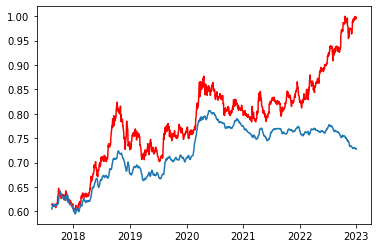

In [11]:
scaled_df.iloc[-len(test_y):].index

DatetimeIndex(['2017-08-14', '2017-08-15', '2017-08-16', '2017-08-17',
               '2017-08-18', '2017-08-21', '2017-08-22', '2017-08-23',
               '2017-08-24', '2017-08-25',
               ...
               '2022-12-19', '2022-12-20', '2022-12-21', '2022-12-22',
               '2022-12-23', '2022-12-26', '2022-12-27', '2022-12-28',
               '2022-12-29', '2022-12-30'],
              dtype='datetime64[ns]', name='Series Description', length=1405, freq=None)